# 实验一：ID3决策树设计——基于决策树的英雄联盟游戏胜负预测

本次以英雄联盟对局胜负预测任务为基础，要求实现决策树算法相关细节，加深对算法的理解，并了解做机器学习任务的大致流程。

## 1 任务介绍
英雄联盟（League of Legends，LoL）是一个多人在线竞技游戏，由拳头游戏（Riot Games）公司出品。在游戏中，每位玩家控制一位有独特技能的英雄，红蓝两支队伍各有五位玩家进行对战，目标是摧毁对方的基地水晶。水晶有多座防御塔保护，通常需要先摧毁一些防御塔再摧毁水晶。玩家所控制的英雄起初非常弱，需要不断击杀小兵、野怪和对方英雄来获得金币、经验。经验可以提升英雄等级和技能等级，金币可以用来购买装备提升攻击、防御等属性。对战过程中一般没有己方单位在附近的地点是没有视野的，即无法看到对面单位，双方可以通过使用守卫来监视某个地点，洞察对面走向、制定战术。
本数据集来自[Kaggle](https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min)，包含了9879场钻一到大师段位的单双排对局，对局双方几乎是同一水平。每条数据是前10分钟的对局情况，每支队伍有19个特征，红蓝双方共38个特征。这些特征包括英雄击杀、死亡，金钱、经验、等级情况等等。一局游戏一般会持续30至40分钟，但是实际前10分钟的局面很大程度上影响了之后胜负的走向。作为最成功的电子竞技游戏之一，对局数据、选手数据的量化与研究具有重要意义，可以启发游戏将来的发展和改进。

本任务是希望同学们依据注释的要求，对代码中空缺部分进行填写，**完成决策树模型的详细实现**，根据已有的对局前10分钟特征信息，预测最后获胜方是蓝色方还是红色方，了解执行一个**机器学习任务的大致流程**，并**提交代码和实验报告**。第一次作业也是一个机器学习小实验的例子，之后的作业可能不再提供预处理等流程代码，由同学们自己设计实验完成代码编写。

## 2 导入工具包
pandas是数据分析和处理常用的工具包，非常适合处理行列表格数据。numpy是数学运算工具包，支持高效的矩阵、向量运算。sklearn是机器学习常用工具包，包括了一些已经实现好的简单模型和一些常用数据处理方法、评价指标等函数。

In [1]:
from collections import Counter
import pandas as pd # 数据处理
import numpy as np # 数学运算
from sklearn.model_selection import train_test_split, cross_validate # 划分数据集函数
from sklearn.metrics import accuracy_score # 准确率函数
RANDOM_SEED = 2023# 固定随机种子

## 3 读入数据
假设数据文件放在`./data/`目录下，标准的csv文件可以用pandas里的`read_csv()`函数直接读入。文件共有40列，38个特征（红蓝方各19），1个标签列（blueWins），和一个对局标号（gameId）。对局标号不是标签也不是特征，可以舍去。

In [2]:
csv_data = './data/high_diamond_ranked_10min.csv' # 数据路径
data_df = pd.read_csv(csv_data, sep=',') # 读入csv文件为pandas的DataFrame
data_df = data_df.drop(columns='gameId') # 舍去对局标号列
data_df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,0,43,1,0,4,5,5,1,0,1,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,4,5,1,1,0,...,0,15246,6.8,16498,229,34,-2519,-2469,22.9,1524.6
9875,1,54,0,0,6,4,8,1,1,0,...,0,15456,7.0,18367,206,56,-782,-888,20.6,1545.6
9876,0,23,1,0,6,7,5,0,0,0,...,0,18319,7.4,19909,261,60,2416,1877,26.1,1831.9
9877,0,14,4,1,2,3,3,1,1,0,...,0,15298,7.2,18314,247,40,839,1085,24.7,1529.8


## 4 数据概览
对于一个机器学习问题，在拿到任务和数据后，首先需要观察数据的情况，比如我们可以通过`.iloc[0]`取出数据的第一行并输出。不难看出每个特征都存成了float64浮点数，该对局蓝色方开局10分钟有小优势。同时也可以发现有些特征列是重复冗余的，比如blueGoldDiff表示蓝色队金币优势，redGoldDiff表示红色方金币优势，这两个特征是完全对称的互为相反数。blueCSPerMin是蓝色方每分钟击杀小兵数，它乘10就是10分钟所有小兵击杀数blueTotalMinionsKilled。在之后的特征处理过程中可以考虑去除这些冗余特征。
另外，pandas有非常方便的`describe()`函数，可以直接通过DataFrame进行调用，可以展示每一列数据的一些统计信息，对数据分布情况有大致了解，比如blueKills蓝色方击杀英雄数在前十分钟的平均数是6.14、方差为2.93，中位数是6，百分之五十以上的对局中该特征在4-8之间，等等。

In [3]:
print(data_df.iloc[0]) # 输出第一行数据
data_df.describe() # 每列特征的简单统计信息

blueWins                            0.0
blueWardsPlaced                    28.0
blueWardsDestroyed                  2.0
blueFirstBlood                      1.0
blueKills                           9.0
blueDeaths                          6.0
blueAssists                        11.0
blueEliteMonsters                   0.0
blueDragons                         0.0
blueHeralds                         0.0
blueTowersDestroyed                 0.0
blueTotalGold                   17210.0
blueAvgLevel                        6.6
blueTotalExperience             17039.0
blueTotalMinionsKilled            195.0
blueTotalJungleMinionsKilled       36.0
blueGoldDiff                      643.0
blueExperienceDiff                 -8.0
blueCSPerMin                       19.5
blueGoldPerMin                   1721.0
redWardsPlaced                     15.0
redWardsDestroyed                   6.0
redFirstBlood                       0.0
redKills                            6.0
redDeaths                           9.0


,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
count,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,...,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000,9879.000000
mean,0.499038,22.288288,2.824881,0.504808,6.183925,6.137666,6.645106,0.549954,0.361980,0.187974,...,0.043021,16489.041401,6.925316,17961.730438,217.349226,51.313088,-14.414111,33.620306,21.734923,1648.904140
std,0.500024,18.019177,2.174998,0.500002,3.011028,2.933818,4.064520,0.625527,0.480597,0.390712,...,0.216900,1490.888406,0.305311,1198.583912,21.911668,10.027885,2453.349179,1920.370438,2.191167,149.088841
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,11212.000000,4.800000,10465.000000,107.000000,4.000000,-11467.000000,-8348.000000,10.700000,1121.200000
25%,0.000000,14.000000,1.000000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,15427.500000,6.800000,17209.500000,203.000000,44.000000,-1596.000000,-1212.000000,20.300000,1542.750000
50%,0.000000,16.000000,3.000000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,0.000000,...,0.000000,16378.000000,7.000000,17974.000000,218.000000,51.000000,-14.000000,28.000000,21.800000,1637.800000
75%,1.000000,20.000000,4.000000,1.000000,8.000000,8.000000,9.000000,1.000000,1.000000,0.000000,...,0.000000,17418.500000,7.200000,18764.500000,233.000000,57.000000,1585.500000,1290.500000,23.300000,1741.850000
max,1.000000,250.000000,27.000000,1.000000,22.000000,22.000000,29.000000,2.000000,1.000000,1.000000,...,2.000000,22732.000000,8.200000,22269.000000,289.000000,92.000000,10830.000000,9333.000000,28.900000,2273.200000


## 5 增删特征
传统的机器学习模型大部分都是基于特征的，因此特征工程是机器学习中非常重要的一步。有时构造一个好的特征比改进一个模型带来的提升更大。这里简单展示一些特征处理的例子。首先，上面提到，特征列中有些特征信息是完全冗余的，会给模型带来不必要的计算量，可以去除。其次，相比于红蓝双方击杀、助攻的绝对值，可能双方击杀英雄的差值更能体现出当前对战的局势。因此，我们可以构造红蓝双方对应特征的差值。数据文件中已有的差值是金币差GoldDiff和经验差ExperienceDiff，实际上每个对应特征都可以构造这样的差值特征。

In [4]:
drop_features = ['blueGoldDiff', 'redGoldDiff', 
                 'blueExperienceDiff', 'redExperienceDiff', 
                 'blueCSPerMin', 'redCSPerMin', 
                 'blueGoldPerMin', 'redGoldPerMin'] # 需要舍去的特征列
df = data_df.drop(columns=drop_features) # 舍去特征列
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,0,28,2,1,9,6,11,0,0,0,...,8,0,0,0,0,16567,6.8,17047,197,55
1,0,12,1,0,5,5,5,0,0,0,...,2,2,1,1,1,17620,6.8,17438,240,52
2,0,15,0,0,7,11,4,1,1,0,...,14,0,0,0,0,17285,6.8,17254,203,28
3,0,43,1,0,4,5,5,1,0,1,...,10,0,0,0,0,16478,7.0,17961,235,47
4,0,75,4,0,6,6,6,0,0,0,...,7,1,1,0,0,17404,7.0,18313,225,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,4,5,1,1,0,...,7,0,0,0,0,15246,6.8,16498,229,34
9875,1,54,0,0,6,4,8,1,1,0,...,3,0,0,0,0,15456,7.0,18367,206,56
9876,0,23,1,0,6,7,5,0,0,0,...,11,1,1,0,0,18319,7.4,19909,261,60
9877,0,14,4,1,2,3,3,1,1,0,...,1,0,0,0,0,15298,7.2,18314,247,40


In [5]:
info_names = [c[3:] for c in df.columns if c.startswith('red')] # 取出要作差值的特征名字（除去red前缀）
info_names

['WardsPlaced',
 'WardsDestroyed',
 'FirstBlood',
 'Kills',
 'Deaths',
 'Assists',
 'EliteMonsters',
 'Dragons',
 'Heralds',
 'TowersDestroyed',
 'TotalGold',
 'AvgLevel',
 'TotalExperience',
 'TotalMinionsKilled',
 'TotalJungleMinionsKilled']

In [6]:
for info in info_names: # 对于每个特征名字
    df['br' + info] = df['blue' + info] - df['red' + info] # 构造一个新的特征，由蓝色特征减去红色特征，前缀为br
# 其中FirstBlood为首次击杀最多有一只队伍能获得，brFirstBlood=1为蓝，0为没有产生，-1为红
df = df.drop(columns=['blueFirstBlood', 'redFirstBlood']) # 原有的FirstBlood可删除
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,...,brAssists,brEliteMonsters,brDragons,brHeralds,brTowersDestroyed,brTotalGold,brAvgLevel,brTotalExperience,brTotalMinionsKilled,brTotalJungleMinionsKilled
0,0,28,2,9,6,11,0,0,0,0,...,3,0,0,0,0,643,-0.2,-8,-2,-19
1,0,12,1,5,5,5,0,0,0,0,...,3,-2,-1,-1,-1,-2908,-0.2,-1173,-66,-9
2,0,15,0,7,11,4,1,1,0,0,...,-10,1,1,0,0,-1172,-0.4,-1033,-17,18
3,0,43,1,4,5,5,1,0,1,0,...,-5,1,0,1,0,-1321,0.0,-7,-34,8
4,0,75,4,6,6,6,0,0,0,0,...,-1,-1,-1,0,0,-1004,0.0,230,-15,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,7,4,5,1,1,0,0,...,-2,1,1,0,0,2519,0.4,2469,-18,35
9875,1,54,0,6,4,8,1,1,0,0,...,5,1,1,0,0,782,0.2,888,27,-8
9876,0,23,1,6,7,5,0,0,0,0,...,-6,-1,-1,0,0,-2416,-0.4,-1877,-51,-15
9877,0,14,4,2,3,3,1,1,0,0,...,2,1,1,0,0,-839,-0.6,-1085,-23,8


## 6 特征离散化
决策树ID3算法一般是基于离散特征的，本例中存在很多连续的数值特征，例如队伍金币。直接应用该算法每个值当作一个该特征的一个取值可能造成严重的过拟合，因此需要对特征进行离散化，即将一定范围内的值映射成一个值，例如对用户年龄特征，将0-10映射到0，11-18映射到1，19-25映射到2，25-30映射到3，等等类似，然后在决策树构建时使用映射后的值计算信息增益。

***本小节要求实现特征离散化，请补全相关代码***

In [7]:
# 查看各参数的值
df.iloc[0]

blueWins                            0.0
blueWardsPlaced                    28.0
blueWardsDestroyed                  2.0
blueKills                           9.0
blueDeaths                          6.0
blueAssists                        11.0
blueEliteMonsters                   0.0
blueDragons                         0.0
blueHeralds                         0.0
blueTowersDestroyed                 0.0
blueTotalGold                   17210.0
blueAvgLevel                        6.6
blueTotalExperience             17039.0
blueTotalMinionsKilled            195.0
blueTotalJungleMinionsKilled       36.0
redWardsPlaced                     15.0
redWardsDestroyed                   6.0
redKills                            6.0
redDeaths                           9.0
redAssists                          8.0
redEliteMonsters                    0.0
redDragons                          0.0
redHeralds                          0.0
redTowersDestroyed                  0.0
redTotalGold                    16567.0


In [8]:
df_c = df.copy() # 先复制一份数据
#检查缺省值
np.all(pd.notnull(df_c))
#分析各列数据，返回唯一值
for column in df_c.columns:
    print(column)
    print(df[column].unique())

blueWins
[0 1]
blueWardsPlaced
[ 28  12  15  43  75  18  16  13  20  33  14  17  21  11  78  19 105  22
  40  24  36  41  37  29 122  52  32  50  83  30  38  87  23  70  10  91
  54  35  86  25  42  68 124  34  31  44  27  57  39  56  46  53  85  76
  48 143  97  51 146  88  62  94  81   9  72  60  26  63  55  65  59 149
  67  80 104  47 123  73  84  45  82 156 165  69 108  49   8 141 111  58
   5 102 128  90  74  77  95  64 117 127 129 138 164 110  93  89 148 120
  92 115  66 132 221  61  71 114 142  79 106 145   7 130 144  99 100 109
 103 183 118 125 209 159 203 198 176 163 126 157 116 167 136 133 151 152
 250 185 137]
blueWardsDestroyed
[ 2  1  0  4  3  5  7  6 13 16  9 11 12 10  8 15 14 18 23 17 19 24 25 21
 22 20 27]
blueKills
[ 9  5  7  4  6 11  3 10  8  2  1 13 12 14  0 15 16 18 17 19 22]
blueDeaths
[ 6  5 11  3 13  7  4  1  9  2  8 10 12 14 17 15  0 16 18 19 22]
blueAssists
[11  5  4  6  7  3  8  1 15 10  9 13  2 12 14  0 18 17 16 22 21 20 25 19
 23 24 29 28 26 27]
blueEliteMon

In [9]:
#列举出唯一值数量小于等于3的属性
Disc_column=[]
for column in df_c.columns:
    if len(df[column].unique())<=3:
        Disc_column.append(column)
        print(column)
        print(df[column].unique())

Disc_column

blueWins
[0 1]
blueEliteMonsters
[0 1 2]
blueDragons
[0 1]
blueHeralds
[0 1]
redEliteMonsters
[0 2 1]
redDragons
[0 1]
redHeralds
[0 1]
redTowersDestroyed
[0 1 2]
brFirstBlood
[ 1 -1]
brDragons
[ 0 -1  1]
brHeralds
[ 0 -1  1]


['blueWins',
 'blueEliteMonsters',
 'blueDragons',
 'blueHeralds',
 'redEliteMonsters',
 'redDragons',
 'redHeralds',
 'redTowersDestroyed',
 'brFirstBlood',
 'brDragons',
 'brHeralds']

请离散化每一列特征，即`discrete_df[c] = ...`

提示：
- 对于有些特征本身取值就很少，可以跳过即 `if ... : continue`
- 对于其他特征，可以使用等区间离散化、等密度离散化或一些其他离散化方法
- 可参考使用`pandas.cut`或`qcut`

In [10]:
discrete_df = df.copy() # 先复制一份数据
# 将需要离散化的特征写入列表中
Disc_column=['blueEliteMonsters','blueDragons','blueHeralds','blueTowersDestroyed',
             'redEliteMonsters','redDragons','redHeralds','redTowersDestroyed',
             'brFirstBlood','brEliteMonsters','brDragons','brHeralds','brTowersDestroyed']
for c in df.columns[1:]: # 遍历每一列特征，跳过标签列
    if c in Disc_column:
        continue
    #利用qcut将数据两等分
    discrete_df[c] = pd.qcut(df[c].rank(method='first'), 2, labels=[0, 1])

## 7 数据集准备
构建机器学习模型前要构建训练和测试的数据集。

在本例中首先需要分开标签和特征，标签是不能作为模型的输入特征的，就好比作业和试卷答案不能在做题和考试前就告诉学生。测试一个模型在一个任务上的效果至少需要训练集和测试集。

训练集用来训练模型的参数，好比学生做作业获得知识，测试集用来测试模型效果，好比期末考试考察学生学习情况。

测试集的样本不应该出现在训练集中，否则会造成模型效果估计偏高，好比考试时出的题如果是作业题中出现过的，会造成考试分数不能准确衡量学生的学习情况，估计值偏高。

划分训练集和测试集有多种方法，下面首先介绍的是随机取一部分如20%作测试集，剩下作训练集。

sklearn提供了相关工具函数`train_test_split`。sklearn的输入输出一般为numpy的array矩阵，需要先将pandas的DataFrame取出为numpy的array矩阵。

In [11]:
all_y = discrete_df['blueWins'].values # 所有标签数据
feature_names = discrete_df.columns[1:] # 所有特征的名称
all_x = discrete_df[feature_names].values # 所有原始特征值，pandas的DataFrame.values取出为numpy的array矩阵

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape # 输出数据行列信息

((9879,), (9879, 43), (7903, 43), (1976, 43), (7903,), (1976,))

In [12]:
# 训练数据集，每行为不同对局的特征参数，每列为同一特征的局内表现
x_train

array([[1, 0, 0, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [13]:
# 训练集标签，每个值为不同对局的blue_win结果
y_train

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

## 8 决策树模型的实现
***本小节要求实现决策树模型，请补全算法代码***

参考：cdsn[链接](https://blog.csdn.net/asialee_bird/article/details/81118245?ops_request_misc=&request_id=&biz_id=102&utm_term=%E5%86%B3%E7%AD%96%E6%A0%91ID3%E4%BB%A3%E7%A0%81&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-1-81118245.142^v96^control&spm=1018.2226.3001.4187)，B站[视频](https://www.bilibili.com/video/BV1KL4y1B7VB?p=29&vd_source=0d9448349c913d93662ef6c2456b7d22)

因为所给的面向对象的架构不好进行模块化测试，于是先将每个功能模块化单拎出来，逐个编写并测试其功能，功能正常后再进行下一步。

1. 设置必要库和参数
   传入一些可能用到的模型参数，也可能不会用到
   
   - classes表示模型分类总共有几类
   - features是每个特征的名字，也方便查询总的共特征数
   - max_depth表示构建决策树时的最大深度
   - min_samples_split表示构建决策树分裂节点时，如果到达该节点的样本数小于该值则不再分裂
   - impurity_t表示计算混杂度（不纯度）的计算方式，例如entropy或gini

In [14]:
from math import log

classes=[0,1]
features=feature_names
min_samples_split = 10
max_depth = 5
impurity_t = 'gini'

2. 建立计算混杂度函数

   根据参数`impurity_t`，来决定混杂度计算方式，分为熵和基尼系数两种方式

   - 熵`entropy`：
     $$
        Entropy(N)=-\sum_{j} P(w_j)log_2P(w_j) \quad
     $$
   - 基尼系数`gini`：
     $$
         Gini(N)=1-\sum_{j} P^2(w_j) \quad
     $$

In [15]:
# 计算混杂度
def impurity(data):
    label_counts = Counter(data)
    total_samples = len(data)
    probability = np.array([label_counts[label] / total_samples for label in label_counts])
    # 选择以熵的形式计算
    if impurity_t == 'entropy':
        return -np.sum(np.multiply(probability, np.log2(probability + 1e-10)))
    # 选择以Gini形式计算
    elif impurity_t == 'gini':
        return 1 - np.sum(np.power(probability, 2))
    else:
        print(f'error: impurity type is {impurity_t}, unable to recognize')

impurity(x_train[0])

0.578691184424013

3. 建立计算信息增益(IG)的函数

   信息增益是由于对A的排序整理带来的熵的期望减少量
   $$
       Gain(S,A)=Impurity(S)-\sum_{v\in Values(A)} \frac{|S_v|}{|S|}Impurity(S_v) \quad
   $$

In [16]:
# 调用impurity用来计算信息增益
def gain(data,label):
    array_sum = np.row_stack((data,label))
    parent_impurity = impurity(label)
    feature_values = set(list(data))
    children_impurity = 0
    for feature in feature_values:
        index = np.where(array_sum[0] == feature)[0]
        weight = len(index)/len(data)
        array_next = array_sum[:, index]
        child_impurity = impurity(array_next[1])
        children_impurity += weight*child_impurity
    return parent_impurity - children_impurity


gain(x_train.T[0],y_train)

0.0010201909666837095

4. 选择最佳特征函数

   调用gain函数，遍历整个特征矩阵，返回最佳信息增益的特征的索引

In [17]:
# 选择最佳特征
def choose_best_feature(features,labels):
    best_feature_index = -1
    max_gain = -1
    for i, feature in enumerate(features.T):
        feature_gain  = gain(feature,labels)
        if feature_gain > max_gain:
            max_gain = feature_gain 
            best_feature_index = i
    return best_feature_index

choose_best_feature(x_train,y_train)

38

5. 返回样本中最多出现的类别

In [18]:
# 返回样本中最多出现的类别
def majorityCnt(labels):
    Cnt = Counter(labels)
    return Cnt.most_common(1)[0][0]

labels_test = [0,1,1,1,0,1,2]
majorityCnt(labels_test)

1

6. 划分数据集函数

   输入为特征矩阵feature，最佳分裂标签索引best_feature_index，标签label，特征值value
   
   该函数根据最佳索引与选取的特征值，将矩阵根据选取的最佳特征的某一特定值分割成新的矩阵

   举例来说，就是将原数据集根据某特征（如双方控龙率）的特征值（0:蓝方高or 1:红方高），分成一个新的数据集，该数据集只包含了该特征的特点特征值的其他特征列。


In [19]:
# 划分数据集
def dividefeat(feature, best_feature_index, label, value):
    refeature = []
    relabel = []
    features = feature.tolist()
    labels = label.tolist()
    for i in range(len(feature)):
        feaVec = features[i]
        if feaVec[best_feature_index] == value:
            subfeat = feaVec[:best_feature_index]
            subfeat.extend(feaVec[best_feature_index + 1:])
            refeature.append(subfeat)
            relabel.append(labels[i])
    return np.array(refeature), np.array(relabel)

best_feature_index = choose_best_feature(x_train,y_train)
subfeature0, sublabel0 = dividefeat(x_train, best_feature_index, y_train, 0)
subfeature1, sublabel1 = dividefeat(x_train, best_feature_index, y_train, 1)

# 原特征矩阵参数
print(f'原特征矩阵行数:{len(x_train)}')
print(f'原特征矩阵列数:{len(x_train[0])}\n')

# 根据特征值0分裂后的数据集参数
print(f'subfeature0:\n{subfeature0}')
print(f'sublabel0:{sublabel0}')
print(f'根据特征值0分裂后矩阵行数:{len(sublabel0)}')
print(f'根据特征值0分裂后矩阵列数:{len(subfeature0[0])}\n')


# 根据特征值1分裂后的数据集参数
print(f'subfeature1:\n{subfeature1}')
print(f'sublabel1:{sublabel1}')
print(f'根据特征值1分裂后矩阵行数:{len(sublabel1)}')
print(f'根据特征值1分裂后矩阵列数:{len(subfeature1[0])}\n')

原特征矩阵行数:7903
原特征矩阵列数:43

subfeature0:
[[1 0 0 ... 0 1 1]
 [1 1 0 ... 0 0 1]
 [1 1 1 ... 0 0 1]
 ...
 [1 1 1 ... 0 1 0]
 [1 1 1 ... 0 1 1]
 [0 1 0 ... 0 0 0]]
sublabel0:[0 0 0 ... 0 0 0]
根据特征值0分裂后矩阵行数:3981
根据特征值0分裂后矩阵列数:42

subfeature1:
[[0 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]
 [0 0 1 ... 1 0 1]
 ...
 [0 1 0 ... 1 0 1]
 [0 1 1 ... 1 0 0]
 [1 1 1 ... 0 0 1]]
sublabel1:[1 1 1 ... 1 0 1]
根据特征值1分裂后矩阵行数:3922
根据特征值1分裂后矩阵列数:42



7. 递归构建决策树的节点

   根据majorityCnt()、choose_best_feature()、dividefeat()函数，递归构建决策树

   用字典来构建决策树，包含选择特征名称与其特征值

In [20]:
# 递归构建决策树的节点
def expand_node(features,labels,depth):
    # 有完全相同的输出类别，labels长度等于第一个label在labels的数量，分裂终止
    if Counter(labels) == 1:
        return labels[0]
    # 如果特征的样本数量小于等于min_samples_split，返回样本中最多出现的类别作为叶节点
    if len(features[0]) <= min_samples_split:
        return majorityCnt(labels)
    if depth > max_depth:
        return majorityCnt(labels)
    # 选择最佳特征索引
    best_feature_index = choose_best_feature(features,labels)
    # 返回最佳特征名称，添加至featLabels中
    best_feature_name = feature_names[best_feature_index]
    # 利用字典，创建最佳特征树
    myTree = {best_feature_name:{}}
    # 获取最佳特征列的值
    featValue = [example[best_feature_index] for example in features]
    # 去掉重复的属性值
    uniqueVals = set(featValue)
    for value in uniqueVals:
        subfeature, sublabel = dividefeat(features, best_feature_index, labels, value)
        myTree[best_feature_name][value] = expand_node(subfeature, sublabel, depth=depth + 1)
    return myTree

expand_node(x_train,y_train,1)

{'brTotalGold': {0: {'brAvgLevel': {0: {'brEliteMonsters': {0: {'brKills': {0: {'brTowersDestroyed': {0: 0,
          1: 0}},
        1: {'redTotalJungleMinionsKilled': {0: 0, 1: 1}}}},
      1: {'brTowersDestroyed': {0: {'blueWardsPlaced': {0: 0, 1: 0}},
        1: {'blueAssists': {0: 0, 1: 1}}}},
      2: {'redTotalGold': {0: {'blueTotalJungleMinionsKilled': {0: 0, 1: 1}},
        1: {'brHeralds': {0: 0, 1: 1}}}},
      -1: {'brTowersDestroyed': {0: {'brDeaths': {0: 0, 1: 0}},
        1: {'redTowersDestroyed': {0: 0, 1: 1}}}},
      -2: {'blueKills': {0: {'brWardsDestroyed': {1: 0, -1: 0}},
        1: {'redHeralds': {0: 0, 1: 0, 2: 1}}}}}},
    1: {'brDragons': {0: {'blueTotalGold': {0: {'redTotalGold': {0: 1, 1: 0}},
        1: {'blueWardsDestroyed': {0: 0, 1: 0}}}},
      1: {'blueKills': {0: {'blueWardsDestroyed': {0: 1, 1: 1}},
        1: {'blueAvgLevel': {0: 0, 1: 1}}}},
      -1: {'blueTotalGold': {0: {'brFirstBlood': {0: 0, 1: 0}},
        1: {'brAssists': {0: 0, -2: 1, -1: 1}

8. 基于面向对象方法，建立决策树类，实现对英雄联盟数据分类

   feature为二维numpy（n*m）数组，每行表示一个样本，有m个特征
    label为一维numpy（n）数组，表示每个样本的分类标签

In [21]:
# 定义决策树类
class DecisionTree(object):
    def __init__(self, classes, features, 
                 max_depth=10, min_samples_split=10,
                 impurity_t='entropy'):
        self.classes = classes
        self.features = features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity_t = impurity_t       
        self.root = None # 定义根节点，未训练时为空

    '''
    函数名称：impurity
    函数说明：
        以熵和基尼两种方式计算标签数据的混杂度
    输入：
        label：NumPy数组类型，数据的标签，只由0,1组成
        self.impurity_t：混杂度计算类型
    返回：
        指定类型的混杂度值，类型错误则报错
    '''
    def impurity(self, label):
        # 统计正负两种数据的数量
        label_counts = Counter(label)
        # 统计数据总长度
        total_samples = len(label)
        probability = np.array([label_counts[label] / total_samples for label in label_counts])
        # 选择以熵的形式计算
        if self.impurity_t == 'entropy':
            return -np.sum(np.multiply(probability, np.log2(probability + 1e-10)))  #添加了一个小常数1e-10来避免np.log2(0)的问题
        # 选择以Gini形式计算
        elif self.impurity_t == 'gini':
            return 1 - np.sum(np.power(probability, 2))
        else:
            print(f'error: impurity type is {self.impurity_t}, unable to recognize')

    '''
    函数名称：gain
    函数说明：
        计算某个特征的信息增益
    输入：
        data：NumPy数组类型，某个特征的所有分类数据
        label：该特征的所有标签
    返回：
        特征增益值
    '''
    def gain(self,data,label):
        # 将单个特征的数据与标签组合成一个二维矩阵
        array_sum = np.row_stack((data,label))
        # 计算父节点混杂度
        parent_impurity = self.impurity(label)
        # 计算子节点个数，即单个特征的分类数量
        feature_values = set(list(data))
        # 将子节点总混杂度赋值为0
        children_impurity = 0
        # 遍历所有子节点，计算子节点总混杂度
        for feature in feature_values:
            # 找到特征为某个类型的索引
            index = np.where(array_sum[0] == feature)[0]
            # 计算该类型的数量占总数比例
            weight = len(index)/len(data)
            # 将数组按该类型取其列
            array_next = array_sum[:, index]
            # 计算该类型的混杂度
            child_impurity = self.impurity(array_next[1])
            children_impurity += weight*child_impurity
        return parent_impurity - children_impurity
    
    '''
    函数名称：choose_best_feature
    函数说明：
        调用gain函数，选取最佳分裂特征
    输入：
        features：输入特征矩阵，每列为一个特征
        labels：对应的标签
    返回：
        最佳分裂特征索引值
    '''
    def choose_best_feature(self,features,labels):
        best_feature_index = -1
        max_gain = -1
        for i, feature in enumerate(features.T):
            feature_gain  = self.gain(feature,labels)
            if feature_gain > max_gain:
                max_gain = feature_gain 
                best_feature_index = i
        return best_feature_index
    
    '''
    函数名称：majorityCnt
    函数说明：
        计算标签中占比最大的属性并返回
    输入：
        labels：一维标签数组
    返回：
        标签中占比最大的值
    '''
    def majorityCnt(self,labels):
        if len(labels) == 0: # 如果列表为空 
            return 0 
        Cnt = Counter(labels)
        return Cnt.most_common(1)[0][0]
    
    '''
    函数名称：dividefeat
    函数说明：
        基于特定值，划分数据集为子集
    输入：
        feature：输入特征矩阵，每列为一个特征
        best_feature_index：最佳分裂特征索引值
        label：对应的标签
        value：标签中特定值
    返回：
        将子特征列表和子标签列表转换为NumPy数组并返回
    '''
    def dividefeat(self, feature, best_feature_index, label, value):
        # 初始化两个空列表，用于存储子特征和子标签
        refeature = []
        relabel = []
        # 将特征和标签数据转换为列表形式
        features = feature.tolist()
        labels = label.tolist()
        # 将特征和标签数据转换为列表形式
        for i in range(len(feature)):
            # 获取当前样本的特征值
            feaVec = features[i]
            # 检查当前样本的特定特征列的值是否等于指定的值
            if feaVec[best_feature_index] == value:
                # 如果值匹配，创建一个子特征向量，不包括特定特征列
                subfeat = feaVec[:best_feature_index]
                subfeat.extend(feaVec[best_feature_index + 1:])
                # 将子特征向量添加到子特征列表
                refeature.append(subfeat)
                # 将相应的子标签添加到子标签列表
                relabel.append(labels[i])
        # 将子特征列表和子标签列表转换为NumPy数组并返回
        return np.array(refeature), np.array(relabel)
    
    '''
    函数名称：expand_node
    函数说明：
        调用choose_best_feature()、dividefeat()、majorityCnt()，利用字典递归生成决策树，
        当输出完全相同、样本数小于标准、层数大于标准则停止生成
        expand_node()训练时递归函数分裂节点，考虑不同情况
        1. 无需分裂 或 达到分裂阈值
        2. 调用gain()找到最佳分裂特征，递归调用expand_node
        3. 找不到有用的分裂特征
    输入：
        features：输入特征矩阵，每列为一个特征
        labels：对应的标签
        depth：递归层数
    返回：
        根节点
    '''
    def expand_node(self,features,labels,depth):
        # 有完全相同的输出类别，labels长度等于第一个label在labels的数量，分裂终止
        if Counter(labels) == 1:
            return labels[0]
        # 如果特征的样本数量小于等于min_samples_split，返回样本中最多出现的类别作为叶节点
        if len(features[0]) <= self.min_samples_split:
            return self.majorityCnt(labels)
        if depth > self.max_depth:
            return self.majorityCnt(labels)
        # 选择最佳特征索引
        best_feature_index = self.choose_best_feature(features,labels)
        # 返回最佳特征名称，添加至featLabels中
        best_feature_name = feature_names[best_feature_index]
        # 利用字典，创建最佳特征树
        myTree = {best_feature_name:{}}
        # 获取最佳特征列的值
        featValue = [example[best_feature_index] for example in features]
        # 去掉重复的属性值
        uniqueVals = set(featValue)
        # 根据不同的属性分裂结点
        for value in uniqueVals:
            # 划分数据集，获取符合当前特征值的子特征和子标签
            subfeature, sublabel = self.dividefeat(features, best_feature_index, labels, value)
            # 递归构建子节点，增加树的深度
            myTree[best_feature_name][value] = self.expand_node(subfeature, sublabel, depth=depth + 1)
        return myTree
        
    '''
    函数名称：fit
    函数说明：
        训练模型，调用expand_node()，训练决策树
        feature为二维numpy（n*m）数组，每行表示一个样本，有m个特征
        label为一维numpy（n）数组，表示每个样本的分类标签
    输入：
        features：输入特征矩阵，每列为一个特征
        labels：对应的标签
    返回：
        无
    '''
    def fit(self, feature, label):
        assert len(self.features) == len(feature[0]) # 输入数据的特征数目应该和模型定义时的特征数目相同
        self.root = self.expand_node(feature, label, depth=1)
    
    '''
    函数名称：traverse_node
    函数说明：
        根据树的结构对输入特征进行分类
        traverse_node()预测时遍历节点，考虑不同情况
        1. 已经到达叶节点，则返回分类结果
        2. 该特征取值在训练集中未出现过
        3. 依据特征取值进入相应子节点，递归调用traverse_node
    输入：
        node：决策树根结点
        feature：输入特征
    返回：
        子节点特征值
    '''
    def traverse_node(self, node, feature):
        # 获取当前节点的特征名
        featname = [name for name in node.keys()][0]
        # 获取当前节点的子节点
        child_Node = [i for i in node[featname].keys()]
        # 获取特征索引值
        fea_index = feature_names.tolist().index(featname)
        # 检查输入特征是否匹配当前节点的子节点，如果不匹配，选择默认子节点
        if feature[fea_index] not in child_Node:
            feature[fea_index] = child_Node[0]
        # 检查当前节点的子节点是否是叶子节点，如果是，返回叶子节点的类别
        if node[featname][feature[fea_index]] in self.classes:
            return node[featname][feature[fea_index]]
        # 如果不是叶子节点，递归进入下一个节点
        return self.traverse_node(node[featname][feature[fea_index]], feature)

    '''
    函数名称：predict
    函数说明：
        预测，调用traverse_node预测分支
        输入feature可以是一个一维numpy数组也可以是一个二维numpy数组
        如果是一维numpy（m）数组则是一个样本，包含m个特征，返回一个类别值
        如果是二维numpy（n*m）数组则表示n个样本，每个样本包含m个特征，返回一个numpy一维数组
    输入：
        特征矩阵
    输出：
        预测标签数组
    '''
    def predict(self, feature):
        assert len(feature.shape) == 1 or len(feature.shape) == 2  # 输入特征可以是1维或2维
        if len(feature.shape) == 1:  # 如果是一个样本
            return self.traverse_node(self.root, feature)  # 从根节点开始路由
        return np.array([self.traverse_node(self.root, f) for f in feature])  # 如果是多个样本
        
# 定义决策树模型，传入算法参数
DT = DecisionTree(classes=[0,1], features=feature_names, max_depth=3, min_samples_split=10, impurity_t='entropy')

DT.fit(x_train, y_train) # 在训练集上训练
p_test = DT.predict(x_test) # 在测试集上预测，获得预测值
print(p_test) # 输出预测值
test_acc = accuracy_score(p_test, y_test) # 将测试预测值与测试集标签对比获得准确率
print('accuracy: {:.4f}'.format(test_acc)) # 输出准确率

[1 1 1 ... 0 0 1]
accuracy: 0.7454


## 9 决策树图形化
根据构建的决策树，利用matplotlib绘制图像

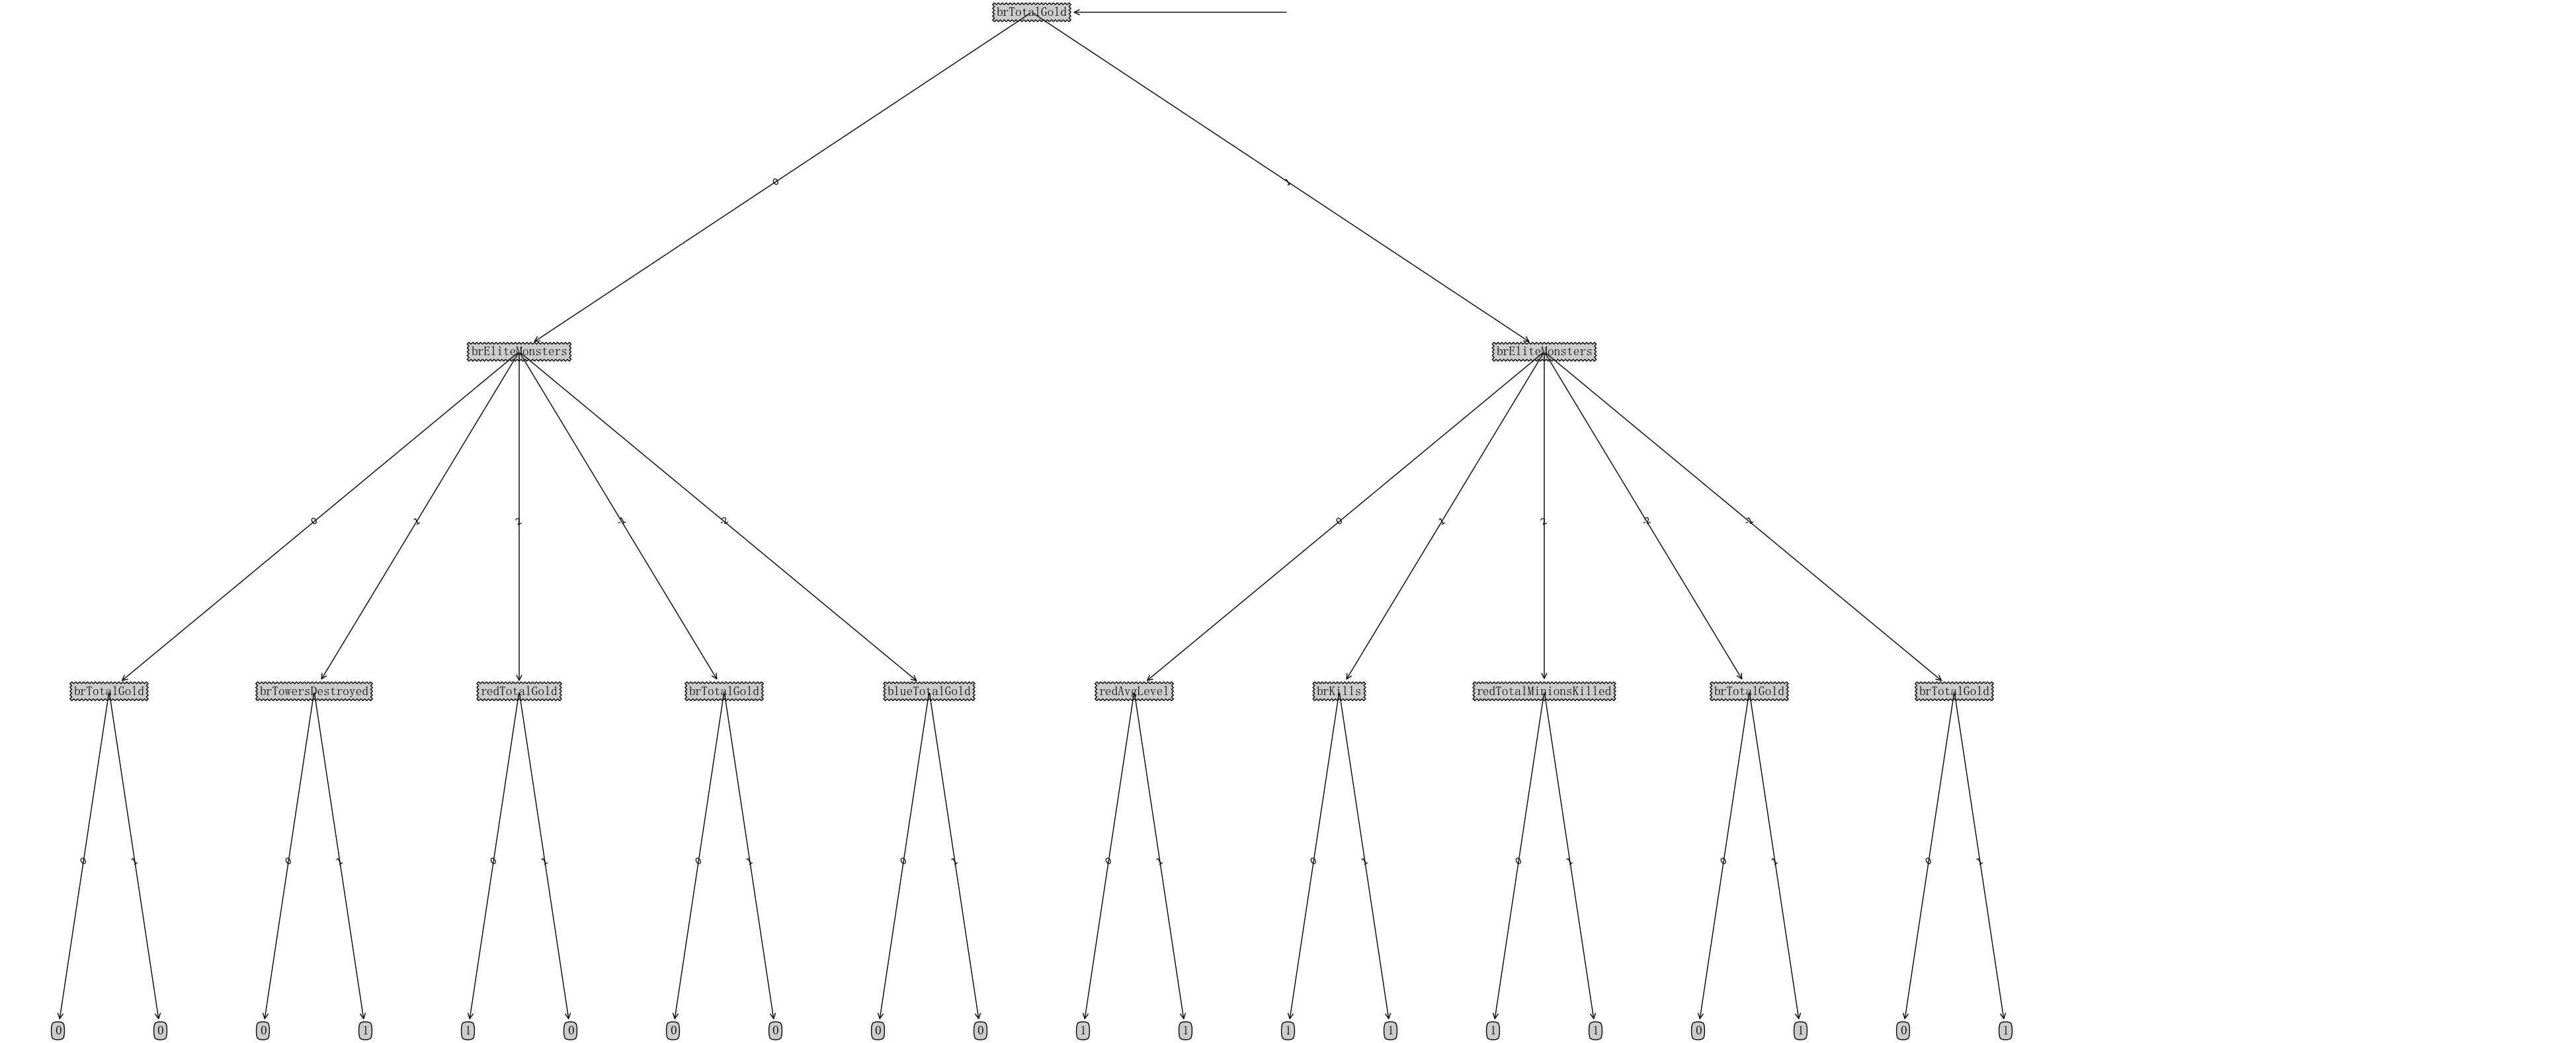

In [22]:
# 导入绘图库和字体管理库
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 定义文本框和箭头格式
decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')

# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)

# 获取决策树叶子结点的数目
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

# 获取决策树的层数
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

# 绘制结点
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    arrow_args = dict(arrowstyle="<-")
    font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args, fontproperties=font)

# 标注有向边属性值
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

# 绘制决策树
def plotTree(myTree, parentPt, nodeTxt):
    decisionNode = dict(boxstyle="sawtooth", fc="0.8")
    leafNode = dict(boxstyle="round4", fc="0.8")
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = next(iter(myTree))
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

# 创建绘制面板
def createPlot(inTree):
    fig = plt.figure(1,figsize=(50, 20), facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))+5
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5 / plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

if __name__ == '__main__':
    mytree = DT.root
    createPlot(mytree)


## 10 模型调优
> 第一次模型测试结果可能不够好，可以先检查调试代码是否有bug，再尝试调整参数或者优化计算方法。

1. 分割数据集采用了直接取中间值对半分的方法，因为发现分3份及以上会降低预测准确率，过拟合比想象中更容易发生
2. 在给的架构中，默认选择了最大深度为5，经过测试深度过深也会造成模型过拟合，实际上反而1层后得到的准确率最高，达到约74%，而五层之后只有约71%，说明实际上后续的特征对决策起到了相反的影响
3. 在给的架构中，默认选择了选择基尼系数来计算混杂度，实际上选择熵效果会更好
4. 最终选择了对半分割数据，以熵为混杂度计算方式，决策树最高4层，准确率达到了74.54%

## 总结
> 一个完整的机器学习任务包括：确定任务、数据分析、特征工程、数据集划分、模型设计、模型训练和效果测试、结果分析和调优等多个阶段，本案例以英雄联盟游戏胜负预测任务为例，给出了每个阶段的一些简单例子，帮助大家入门机器学习，希望大家有所收获！

通过参加张敏教授的决策树课程学习，我不仅掌握了决策树的基本原理和应用，而且还成功完成了本次实验，在实验过程中也积累了丰富的经验和收获。

在程序设计中我面临了一些挑战，特别是在处理Python的各种数据结构和语法方面，我对它们的掌握程度相对较浅。然而，通过查阅网络资料和借助ChatGPT等工具的帮助，我最终能够找到适当的解决方案，提高了对Python语法的理解和掌握。

实验结果表明，过拟合问题比我想象中的更容易发生，而增加分类数量并不一定带来更高的准确率。这次实验使我首次全面体验了机器学习任务的完整流程，包括任务确定、数据分析、特征工程、数据集划分、模型设计、模型训练、效果测试、结果分析和调优等多个环节。由于我编程基础相对薄弱，使得实验设计和完成的效率不够高，但最终借助着ChatGPT等工具的帮助，使得我遇到问题后，大多数都得到了很好的解决。